In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
import json
import matplotlib.pyplot as plt



In [2]:
with open("./dataset.JSON", 'r', encoding='utf-8') as file:
    data = json.load(file)



In [3]:
user_ids = []
item_titles = []
ratings = []

# Convert userID and book titles into numeric form using LabelEncoder
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Prepare the data
for entry in data:
    user_id = entry["userID"]
    for recommendation in entry["recommendation"]:
        item_title = recommendation["title"]
        user_ids.append(user_id)
        item_titles.append(item_title)
        ratings.append(np.random.randint(1, 6))  # Assign random ratings for demonstration purposes

user_ids = user_encoder.fit_transform(user_ids)
item_titles = item_encoder.fit_transform(item_titles)


In [4]:
df = pd.DataFrame({
    'userID': user_ids,
    'itemID': item_titles,
    'rating': ratings
})


In [5]:
X = df[['userID', 'itemID']]
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Jumlah data pelatihan: {X_train.shape[0]} data")
print(f"Jumlah data pengujian: {X_test.shape[0]} data")



Jumlah data pelatihan: 349 data
Jumlah data pengujian: 88 data


In [6]:
embedding_size = 50

# Define the model with regularization, batch normalization, and dropout
user_input = layers.Input(shape=(1,))
item_input = layers.Input(shape=(1,))

# Embedding layers for user and item
user_embedding = layers.Embedding(len(user_encoder.classes_), embedding_size)(user_input)
item_embedding = layers.Embedding(len(item_encoder.classes_), embedding_size)(item_input)

# Flatten the embedding outputs
user_vec = layers.Flatten()(user_embedding)
item_vec = layers.Flatten()(item_embedding)

# Concatenate the user and item vectors
concat = layers.concatenate([user_vec, item_vec])

# Add dense layers with L2 regularization, batch normalization, and increased dropout rate
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(concat)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.7)(x)  # Increasing dropout to avoid overfitting

x = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.7)(x)  # Increasing dropout to avoid overfitting

output = layers.Dense(1)(x)

# Create the model
model = models.Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')



In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.01,
    verbose=1
)

def scheduler(epoch, lr):
    if epoch > 5 and epoch % 10 == 0:
        return lr * 0.1
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)



In [8]:
history = model.fit(
    [X_train['userID'], X_train['itemID']], y_train,
    epochs=50,  # Increased number of epochs
    batch_size=32,
    validation_data=([X_test['userID'], X_test['itemID']], y_test),
    callbacks=[early_stopping, lr_scheduler]
)



Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 17.9894 - val_loss: 11.2571 - learning_rate: 5.0000e-04
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.4475 - val_loss: 10.9706 - learning_rate: 5.0000e-04
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.1257 - val_loss: 10.7379 - learning_rate: 5.0000e-04
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.0440 - val_loss: 10.5084 - learning_rate: 5.0000e-04
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.8480 - val_loss: 10.2458 - learning_rate: 5.0000e-04
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.8933 - val_loss: 10.0333 - learning_rate: 5.0000e-04
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.5391 - val_loss: 9.8217 - learning_rate: 5.0000e-04
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.1826 - val_loss: 9.6242 - learning_rate: 5.0000e-04
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.6265 - val_loss: 9.4523 - le

In [9]:
test_loss = model.evaluate([X_test['userID'], X_test['itemID']], y_test)
print(f"Test Loss: {test_loss}")



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0367 
Test Loss: 9.105111122131348


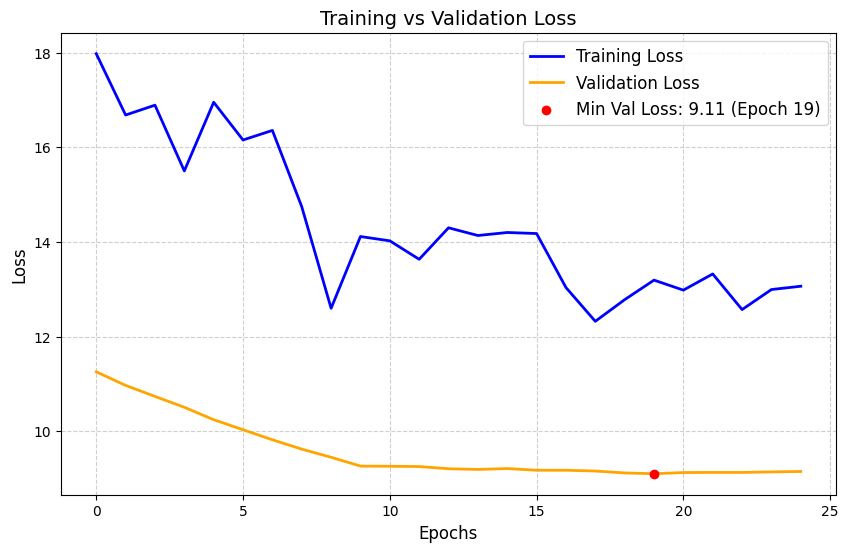

In [10]:
plt.figure(figsize=(10, 6))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)

# Mark the minimum validation loss
min_val_loss = min(history.history['val_loss'])
min_val_epoch = history.history['val_loss'].index(min_val_loss)
plt.scatter(min_val_epoch, min_val_loss, color='red', label=f"Min Val Loss: {min_val_loss:.2f} (Epoch {min_val_epoch})", zorder=5)

# Add title and labels
plt.title('Training vs Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()



In [11]:
def generate_recommendations(user_id, emotion_dominant):
    # Cari data pengguna di dataset berdasarkan user_id
    user_data = None
    for entry in data:
        if entry["userID"] == user_id:
            user_data = entry
            break

    # Jika user tidak ditemukan
    if user_data is None:
        return {"msgEmotion": "User tidak ditemukan", "recommendation": []}

    # Mengambil emotionDominant dari dataset
    emotion_dominant_data = user_data["emotionDominant"]  # Emosi dominan dari dataset
    msg_emotion = user_data["msgEmotion"]  # Pesan emosi dari dataset

    # Mencocokkan emosi input dengan emosi dominan yang ada di dataset
    matched_emotions = []
    for emotion in emotion_dominant:
        emotion_lower = emotion.strip().lower()
        
        # Cek apakah emosi input ada di dalam emotionDominant
        if emotion_lower in [e.lower() for e in emotion_dominant_data]:
            matched_emotions.append(f"Emosi '{emotion}' cocok dengan data emosi dominan.")

    # Gabungkan emosi yang cocok ke dalam pesan jika ada
    if matched_emotions:
        msg_emotion =  msg_emotion
    else:
        # Jika tidak ada emosi yang cocok, gunakan msgEmotion dari dataset langsung
        msg_emotion = msg_emotion

    # Mengonversi user_id menjadi bentuk numerik
    recommendations = []
    try:
        user_id_num = user_encoder.transform([user_id])[0]  # Konversi user ID menjadi numerik
    except ValueError as e:
        print(f"Error converting user_id: {e}")
        return {"msgEmotion": "Emosi tidak dikenali", "recommendation": []}

    # Mengambil item yang direkomendasikan berdasarkan prediksi rating
    item_ids = np.arange(len(item_encoder.classes_))  # Daftar ID item
    predicted_ratings = model.predict([np.full_like(item_ids, user_id_num), item_ids])  # Prediksi rating

    # Urutkan item berdasarkan rating yang diprediksi
    top_items = item_ids[np.argsort(predicted_ratings.flatten())[-5:]]  # Ambil 5 item terbaik

    seen_titles = set()

    # Menambahkan item yang direkomendasikan
    for item_id in top_items:
        item_title = item_encoder.inverse_transform([item_id])[0]
        for entry in data:
            for recommendation in entry['recommendation']:
                if recommendation["title"] == item_title and item_title not in seen_titles:
                    recommendations.append({
                        "title": recommendation["title"],
                        "image": recommendation["image"],
                        "desc": recommendation["desc"],
                        "type": recommendation["type"]
                    })
                    seen_titles.add(item_title)
                    break

    return {
        "msgEmotion": msg_emotion,
        "recommendation": recommendations[:5]  # Mengembalikan 5 rekomendasi teratas
    }
# %% Test the recommendation generation with dominant emotions
user_recommendations = generate_recommendations("35", ["Senang", "Bahagia", "Terharu"])

# Display the recommendations in a tabular format using IPython display
display(pd.DataFrame(user_recommendations["recommendation"])[['title', 'image', 'desc', 'type']])


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,title,image,desc,type
0,Studio Alam Gamplong,https://picsum.photos/seed/70/200/300,Studio Gamplong atau Studio Alam Gamplong adal...,destinasi
1,Taman Badak,https://picsum.photos/seed/380/200/300,Taman Badak ini baru saja diresmikan pada tang...,destinasi
2,Museum Sepuluh Nopember Kota Surabaya,https://picsum.photos/seed/560/200/300,Museum Sepuluh November Surabaya adalah salah ...,destinasi
3,Hutan Bambu Keputih,https://picsum.photos/seed/406/200/300,Surabaya menjadi kota metropolitan kedua setel...,destinasi
4,Museum Tekstil,https://picsum.photos/seed/905/200/300,Museum cinta Tekstil menempati gedung tua di J...,destinasi


In [12]:
user_recommendations = generate_recommendations("32", ["Cemas", "Kesal", "Terharu"])

print("Pesan Emosi:", user_recommendations["msgEmotion"])

# Display the recommendations in a tabular format using IPython display
display(pd.DataFrame(user_recommendations["recommendation"])[['title', 'image', 'desc', 'type']])


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Pesan Emosi: Kamu Kebahagiaan yang menyebar membuat hati ringan dan ceria.


,title,image,desc,type
0,Masjid Salman ITB,https://picsum.photos/seed/81/200/300,Masjid Salman ITB adalah masjid kampus yang te...,destinasi
1,Lawang Sewu,https://picsum.photos/seed/353/200/300,"Lawang Sewu (""Seribu Pintu"") (bahasa Jawa: ꦭꦮꦁ...",destinasi
2,Hutan Bambu Keputih,https://picsum.photos/seed/406/200/300,Surabaya menjadi kota metropolitan kedua setel...,destinasi
3,Masjid Agung Trans Studio Bandung,https://picsum.photos/seed/172/200/300,Masjid Agung Trans Studio Bandung (TSB) berdir...,destinasi
4,Bendung Lepen,https://picsum.photos/seed/323/200/300,Bendung Lepen sendiri dulunya merupakan salura...,destinasi
